# Adaptive Boosting Technique

## Load required libraries

In [1]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
import sklearn
print(sklearn.__version__)

0.23.2


## Load dataset and set discrete popularity

In [6]:
df = pd.read_csv('../dataset/data_merged.csv')
mean_popularity = 50
df["popularity"] = [ 1 if i >= mean_popularity else 0 for i in df.popularity ]
df["popularity"].head()

0    0
1    0
2    0
3    0
4    0
Name: popularity, dtype: int64

## Initiate sklearn's AdaBoostClassifier

In [83]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=1)

## Prepare and split data to train and test set

In [11]:
X  = df.drop(['popularity'], axis=1)
y = df['popularity']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

## Train the model

In [86]:
ada_clf.fit(X_train, np.ravel(y_train))

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=1, n_estimators=100)

## Testing model

In [87]:
y_train_pred = ada_clf.predict(X_train)

In [88]:
accuracy_score(y_train, y_train_pred)

0.9398623933112699

In [89]:
y_pred = ada_clf.predict(X_test)

In [90]:
accuracy_score(y_test, y_pred)

0.9103234047494629

In [91]:
print(confusion_matrix(y_test, y_pred))
print("Classification report\n")
print(classification_report(y_test, y_pred))

[[27673  1051]
 [ 2038  3684]]
Classification report

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     28724
           1       0.78      0.64      0.70      5722

    accuracy                           0.91     34446
   macro avg       0.85      0.80      0.83     34446
weighted avg       0.91      0.91      0.91     34446



## Bayesian Optimization for finding appropriate hyperparameters

In [7]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.8.1-py2.py3-none-any.whl (101 kB)
  Using cached pyaml-20.4.0-py2.py3-none-any.whl (17 kB)
     |████████████████████████████████| 662 kB 321 kB/s eta 0:00:01


In [22]:
!pip install matplotlib

     |████████████████████████████████| 10.3 MB 501 kB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 6.4 MB/s eta 0:00:01


In [23]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective
from matplotlib import pyplot as plt

In [14]:
opt = BayesSearchCV(
    AdaBoostClassifier(),
    {
        'n_estimators' : Integer(50, 250),
        'learning_rate' : Real(0.01, 1.0),
#         'C': (1e-6, 1e+6, 'log-uniform'),
#         'gamma': (1e-6, 1e+1, 'log-uniform'),
#         'degree': (1, 8),  # integer valued parameter
#         'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)


In [15]:
opt.fit(X_train, y_train)


BayesSearchCV(cv=3, estimator=AdaBoostClassifier(), n_iter=32,
              search_spaces={'learning_rate': Real(low=0.01, high=1.0, prior='uniform', transform='identity'),
                             'n_estimators': Integer(low=50, high=250, prior='uniform', transform='identity')})

## Best parameters and scores obtained

In [16]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

val. score: 0.91790048191372
test score: 0.917842420019741
best params: OrderedDict([('learning_rate', 0.16172069319067575), ('n_estimators', 200)])


In [17]:
y_pred = opt.predict(X_test)

In [18]:
print(confusion_matrix(y_test, y_pred))
print("Classification report\n")
print(classification_report(y_test, y_pred))

[[28037   687]
 [ 2143  3579]]
Classification report

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     28724
           1       0.84      0.63      0.72      5722

    accuracy                           0.92     34446
   macro avg       0.88      0.80      0.83     34446
weighted avg       0.91      0.92      0.91     34446



## Visualize results with partial dependence plots

array([[<AxesSubplot:xlabel='n_estimators', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='n_estimators', ylabel='learning_rate'>,
        <AxesSubplot:xlabel='learning_rate', ylabel='Partial dependence'>]],
      dtype=object)

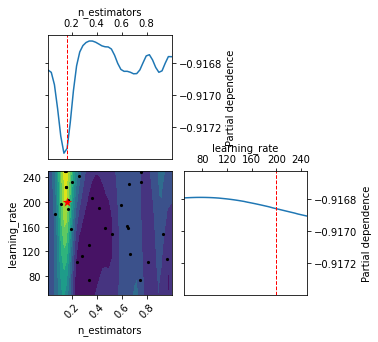

In [24]:
plot_objective(opt.optimizer_results_[0],
                   dimensions=["n_estimators", "learning_rate"],
                   n_minimum_search=int(1e8))